<div class="alert alert-block alert-success">
    <h3 align="center">Desafio Cientista de Dados Indicium - Ferramenta de Precificação de Valor de Diárias de Imóvel</h3>
    <h4 align="center">Moisés Victor</h4>
</div>

### Contexto

O time da Indicium está trabalhando atualmente junto a um cliente no processo de criação de uma plataforma de aluguéis temporários na cidade de Nova York. Para o desenvolvimento de sua estratégia de precificação, pediu para que a Indicium fizesse uma análise exploratória dos dados de seu maior concorrente, assim como um teste de validação de um modelo preditivo.

### Objetivo

Desenvolver um modelo de previsão de preços a partir do dataset oferecido, e avaliar tal modelo utilizando as métricas de avaliação que mais fazem sentido para o problema. Além disso, sugerir um preço para um apartamento com as seguintes características:

'id': 2595,<br>
'nome': 'Skylit Midtown Castle',<br>
'host_id': 2845,<br>
'host_name': 'Jennifer',<br>
'bairro_group': 'Manhattan',<br>
'bairro': 'Midtown',<br>
'latitude': 40.75362,<br>
'longitude': -73.98377,<br>
'room_type': 'Entire home/apt',<br>
'minimo_noites': 1,<br>
'numero_de_reviews': 45,<br>
'ultima_review': '2019-05-21',<br>
'reviews_por_mes': 0.38,<br>
'calculado_host_listings_count': 2,<br>
'disponibilidade_365': 355<br>

### O que temos disponível, inspirações e créditos

A bases de dados foi disponibilizada pelo pessoal responsável pelo desafio e contém uma várias listagens de imóves com suas características, como:
- id: Atua como uma chave exclusiva para cada anúncio nos dados do aplicativo
- nome: Representa o nome do anúncio
- host_id: Representa o id do usuário que hospedou o anúncio
- host_name – Contém o nome do usuário que hospedou o anúncio
- bairro_group: Contém o nome do bairro onde o anúncio está localizado
- bairro: Contém o nome da área onde o anúncio está localizado
- latitude: Contém a latitude do local
- longitude: Contém a longitude do local
- room_type – Contém o tipo de espaço de cada anúncio
- price: Contém o preço por noite em dólares listado pelo anfitrião
- minimo_noites: Contém o número mínimo de noites que o usuário deve reservar
- numero_de_reviews: Contém o número de comentários dados a cada listagem
- ultima_review: Contém a data da última revisão dada à listagem
- reviews_por_mes: Contém o número de avaliações fornecidas por mês
- calculado_host_listings_count: Contém a quantidade de listagem por host
- disponibilidade_365: Contém o número de dias em que o anúncio está disponível para reserva

### Expectativas Iniciais

- A localização do imóvel pode influenciar no preço, já que em Nova York a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- A quantidade de avaliações também pode influenciar o preço. Um imóvel com muitos reviews provavelmente é muito procurado, o que tende a aumentar o seu valor.
- O tipo de quarto é outro fator relevante, pois as preferências pessoais podem variar. Algumas pessoas podem evitar alugar determinados imóveis devido à natureza do quarto oferecido.

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### 1. Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import time
import joblib
from joblib import dump, load

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import svm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import sys

In [2]:
print("Versão do Pandas: ", pd.__version__)
print("Versão do Numpy: ", pd.__version__)
print("Versão do Seaborn: ", sns.__version__)
print("Versão do Matplotlib: ", matplotlib.__version__)
print("Versão do Scikit-Learn: ", sklearn.__version__)
print("Versão do Python: ", sys.version)
print("Versão do Joblib: ", joblib.__version__)

Versão do Pandas:  2.2.2
Versão do Numpy:  2.2.2
Versão do Seaborn:  0.13.2
Versão do Matplotlib:  3.9.2
Versão do Scikit-Learn:  1.5.1
Versão do Python:  3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
Versão do Joblib:  1.4.2


In [3]:
# Importando a base de dados
df = pd.read_csv('teste_indicium_precificacao.csv')

In [4]:
# Exibindo apenas as 5 primeiras linhas para fazer um reconhecimento dos dados que temos
df.head()

id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150              3                  0           NaN   
2  Entire home/apt     89              1                270    2019-07-05   
3  Entire home/apt     80             10                  9    2018-11-19   
4  Entire home/apt    200              3                 74    2019-06-22   

   reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
0             0.38                              2                  355  
1              NaN                              1                  365  
2             4.64                              1                  194  
3             0.10                              1                    0  
4             0.59                              1                  129

### 2. Tratar Valores Faltando

In [5]:
# Verificar a quantidade de amostras
print(df.shape)

# Verificar a quantidade de valores nulos em cada coluna
print(df.isnull().sum())

(48894, 16)
id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


- A partir desta análise, percebemos que existe uma certa quantidade de dados faltantes. Das 48894 amostras as colunas 'ultima_review' e 'reviews_por_mes' possuem 10052 valores nulos. Como são muitos dados para serem excluídos (~20,5%), temos duas opções: Excluir as colunas ou preenchê-las com algum valor que faça sentido. Vamos analisar mais a fundo e verificar o por quê desses valores estarem nulos e tomar a melhor decisão para cada caso.

In [6]:
# Selecionar apenas os valores NaN e manter a coluna 'numero_de_reviews'
nan_mask = df[['ultima_review', 'reviews_por_mes']].isna()
nan_df = df[nan_mask.any(axis=1)][['numero_de_reviews']] # Mantém apenas reviews originais 
nan_df['ultima_review'] = df['ultima_review'][nan_mask['ultima_review']]
nan_df['reviews_por_mes'] = df['reviews_por_mes'][nan_mask['reviews_por_mes']]

display(nan_df)

numero_de_reviews ultima_review  reviews_por_mes
1                      0           NaN              NaN
18                     0           NaN              NaN
25                     0           NaN              NaN
35                     0           NaN              NaN
37                     0           NaN              NaN
...                  ...           ...              ...
48889                  0           NaN              NaN
48890                  0           NaN              NaN
48891                  0           NaN              NaN
48892                  0           NaN              NaN
48893                  0           NaN              NaN

[10052 rows x 3 columns]

In [7]:
nan_df['numero_de_reviews'].value_counts()

numero_de_reviews
0    10052
Name: count, dtype: int64

- Percebemos que as 10052 listagens com valores NaN nas colunas 'ultima_review' e 'reviews_por_mes' são devido ao fato de não ter nenhum review para essas listagens.
- Sendo assim, como não temos uma forma de preencher a data de 'ultima_review' para esses casos, vamos excluir essa coluna. Já no caso de 'reviews_por_mes' vamos inserir o valor de 0 para estes casos.

In [8]:
# Substituir valores NaN na coluna 'reviews_por_mes' por 0
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

- Para as colunas 'nome' e 'host_name', vamos excluir as linhas que possuem valores NaN já que representam uma quantidade muito pequena da base de dados.

In [9]:
# Retirando os dados NaN do dataframe:
df = df.dropna()

In [10]:
# Verificando novamente os valores nulos
print(df.isnull().sum())
print(df.shape)

id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
dtype: int64
(38820, 16)


### 3. Análise Exploratória e Tratar Outliers

#### 3.1. Verificar Tipos de Dados em cada coluna

In [11]:
print(df.dtypes)

id                                 int64
nome                              object
host_id                            int64
host_name                         object
bairro_group                      object
bairro                            object
latitude                         float64
longitude                        float64
room_type                         object
price                              int64
minimo_noites                      int64
numero_de_reviews                  int64
ultima_review                     object
reviews_por_mes                  float64
calculado_host_listings_count      int64
disponibilidade_365                int64
dtype: object


- Ótimo, todas as colunas com exceção de bairro e bairro_group estão sendo reconhecidas como tipo numérico. Iremos tratá-las mais adiante

In [12]:
df['price'].describe()

count    38820.000000
mean       142.332354
std        196.997290
min          0.000000
25%         69.000000
50%        101.000000
75%        170.000000
max      10000.000000
Name: price, dtype: float64

Há algumas inconsistências na coluna de preço: 
- O valor mínmo de preço igual a 0;
- Uma diferença muito grande entre o valor do desvio padrão e a diferença entre o valor máximo e 3º quartil, sugerindo a presença de outliers.

In [13]:
# Verificando as listagens com preço igual a 0
df.loc[df['price']==0,:]

id                                               nome    host_id  \
23160  18750597  Huge Brooklyn Brownstone Living, Close to it all.    8993084   
25432  20333471      ★Hostel Style Room | Ideal Traveling Buddies★  131697576   
25633  20523843    MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)   15787004   
25752  20608117                    Sunny, Quiet Room in Greenpoint    1641537   
25777  20624541      Modern apartment in the heart of Williamsburg   10132166   
25793  20639628  Spacious comfortable master bedroom with nice ...   86327101   
25794  20639792  Contemporary bedroom in brownstone with nice view   86327101   
25795  20639914       Cozy yet spacious private brownstone bedroom   86327101   
26840  21291569  Coliving in Brooklyn! Modern design / Shared room  101970559   
26865  21304320             Best Coliving space ever! Shared room.  101970559   

          host_name bairro_group              bairro  latitude  longitude  \
23160      Kimberly     Brooklyn  Bedford-Stuyvesant  40.69023  -73.95428   
25432        Anisha        Bronx     East Morrisania  40.83296  -73.88668   
25633  Martial Loft     Brooklyn            Bushwick  40.69467  -73.92433   
25752        Lauren     Brooklyn          Greenpoint  40.72462  -73.94072   
25777       Aymeric     Brooklyn        Williamsburg  40.70838  -73.94645   
25793       Adeyemi     Brooklyn  Bedford-Stuyvesant  40.68173  -73.91342   
25794       Adeyemi     Brooklyn  Bedford-Stuyvesant  40.68279  -73.91170   
25795       Adeyemi     Brooklyn  Bedford-Stuyvesant  40.68258  -73.91284   
26840        Sergii     Brooklyn            Bushwick  40.69211  -73.90670   
26865        Sergii     Brooklyn            Bushwick  40.69166  -73.90928   

             room_type  price  minimo_noites  numero_de_reviews ultima_review  \
23160     Private room      0              4                  1    2018-01-06   
25432     Private room      0              2                 55    2019-06-24   
25633     Private room      0              2                 16    2019-05-18   
25752     Private room      0              2                 12    2017-10-27   
25777  Entire home/apt      0              5                  3    2018-01-02   
25793     Private room      0              1                 93    2019-06-15   
25794     Private room      0              1                 95    2019-06-21   
25795     Private room      0              1                 95    2019-06-23   
26840      Shared room      0             30                  2    2019-06-22   
26865      Shared room      0             30                  5    2019-05-24   

       reviews_por_mes  calculado_host_listings_count  disponibilidade_365  
23160             0.05                              4                   28  
25432             2.56                              4                  127  
25633             0.71                              5                    0  
25752             0.53                              2                    0  
25777             0.15                              1                   73  
25793             4.28                              6                  176  
25794             4.37                              6                  232  
25795             4.35                              6                  222  
26840             0.11                              6                  333  
26865             0.26                              6                  139

In [14]:
df.loc[df['price']==0,:].shape[0]

10

- **Existem portanto 11 amostras com preço igual a 0. É bastante provável que seja algum erro de digitação e portanto não devemos levar essas listagens em consideração.**
- **Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acimda de Q3 + 1.5xAmplitude). Amplitude = Q3 - Q1**

In [15]:
# Excluindo as listagens com preço igual a 0
df = df.drop(df.loc[df['price']==0,:].index)

In [16]:
# Função para retornar os limites superior e inferior em uma determinada coluna
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5*amplitude, q3 + 1.5*amplitude

# Função para excluir outliers. Esta função recebe como parâmentro o dataframe e o nome da coluna, e utiliza a função de limites criada acima. 
# Retorna o dataframe com as linhas removidas e a quantidade de linhas removidas.
def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    # Calula a quantidade de linhas removidas
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas

# Função para criar 2 boxplots. Um para todo o intervalo de valores e outro apenas com os valores dentro dos limites superior e inferior
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

# Função para criar histograma e verificar a distribuição dos valores
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.histplot(coluna, kde=True, stat="density", kde_kws=dict(cut=3))

# Função para criar um gráfico de barras, que será útil em alguns casos
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index , y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

#### 3.2. Para a coluna 'price', temos o seguinte:

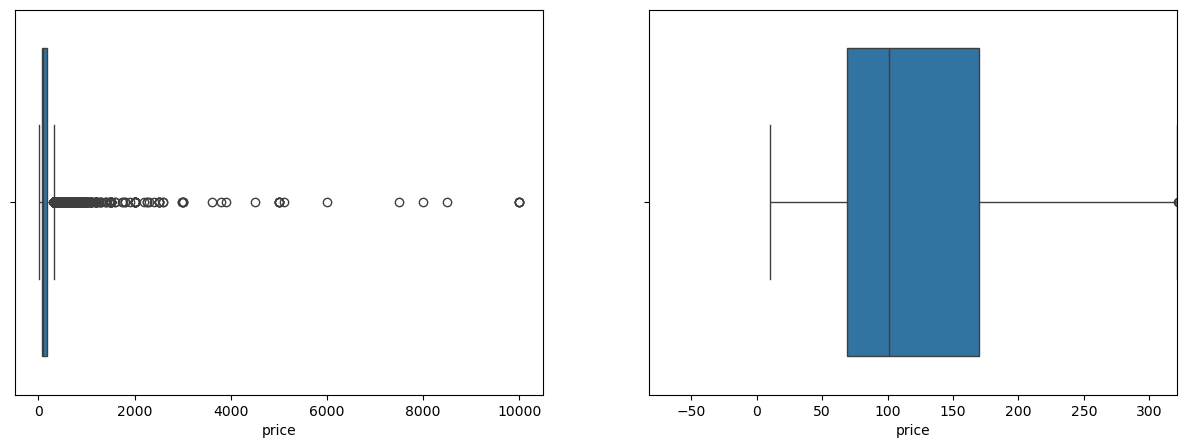

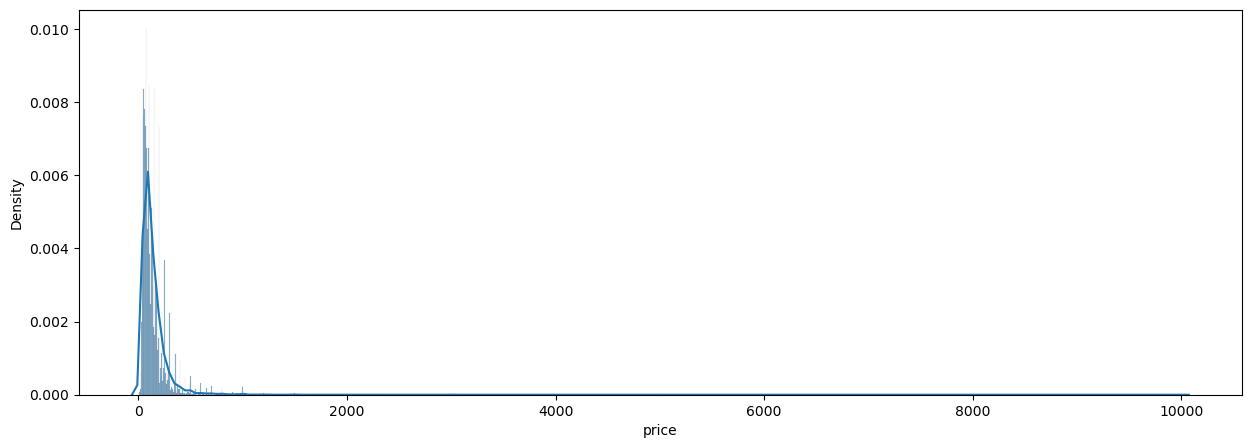

In [17]:
diagrama_caixa(df['price'])
histograma(df['price'])

In [18]:
li, ls = limites(df['price'])
print(f'LS: {ls}, LI: {li}')

LS: 321.5, LI: -82.5


In [19]:
df, linhas_removidas = excluir_outliers(df, 'price')
print('{} linhas removidas'.format(linhas_removidas))

2077 linhas removidas


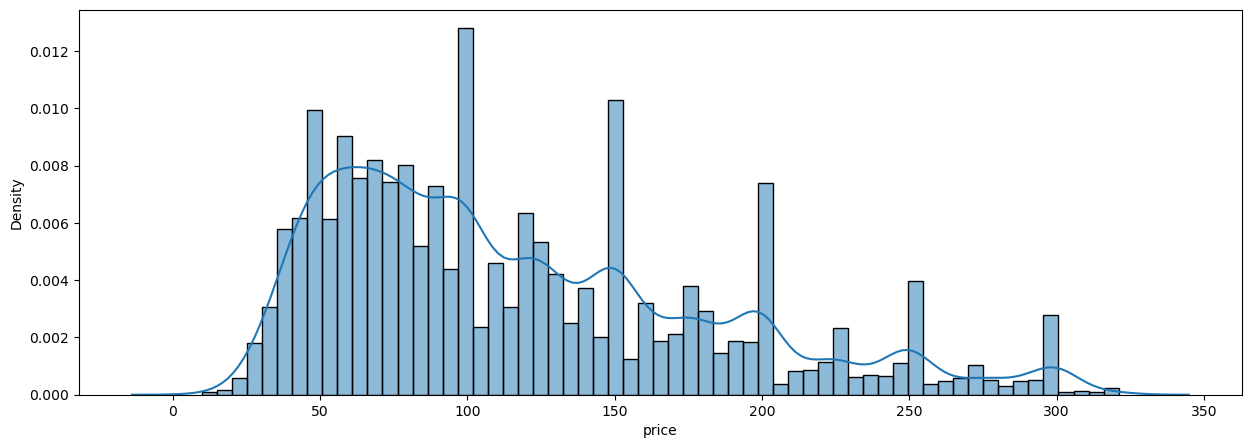

In [20]:
# Verificando o histograma para a coluna após a remoção dos outliers
histograma(df['price'])

#### 3.3. Agora, para a coluna 'minimo_noites':

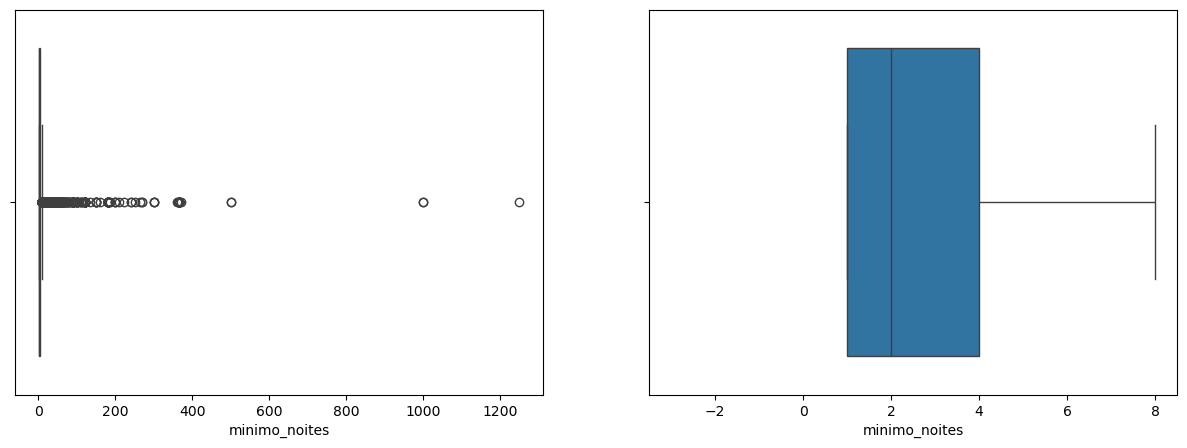

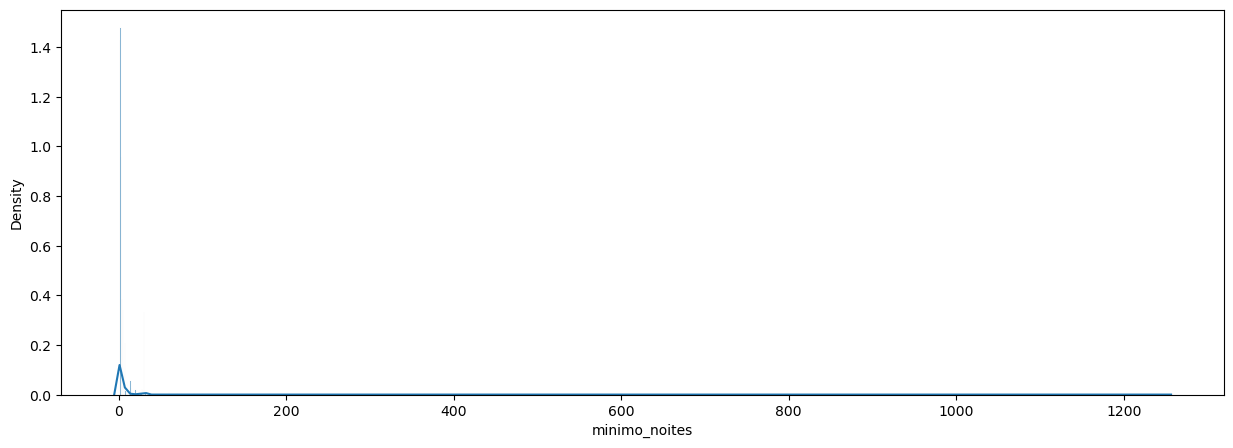

In [21]:
diagrama_caixa(df['minimo_noites'])
histograma(df['minimo_noites'])

In [22]:
li, ls = limites(df['minimo_noites'])
print(f'LS: {ls}, LI: {li}')

LS: 8.5, LI: -3.5


In [23]:
df, linhas_removidas = excluir_outliers(df, 'minimo_noites')
print('{} linhas removidas'.format(linhas_removidas))

4268 linhas removidas


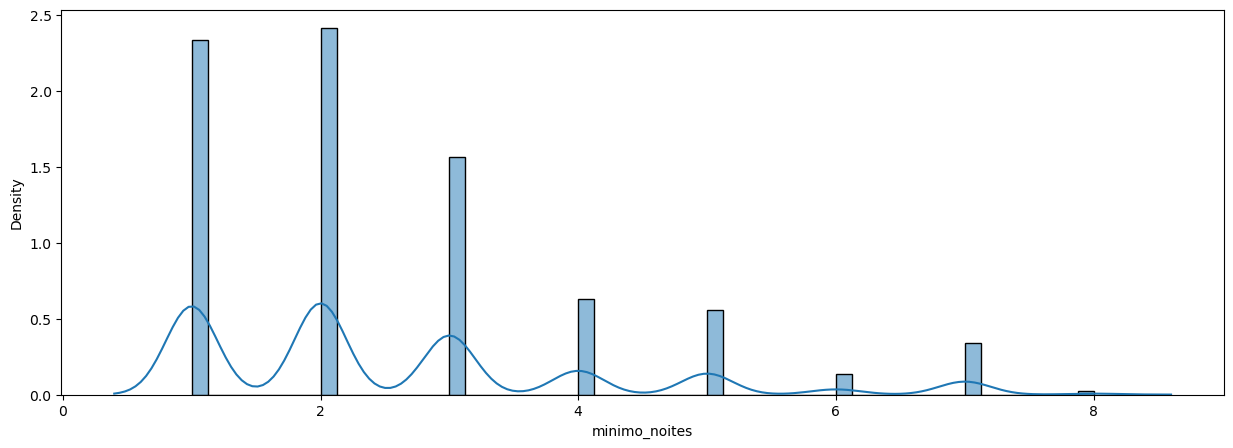

In [24]:
# Verificando o histograma para a coluna após a remoção dos outliers
histograma(df['minimo_noites'])

#### 3.4 numero_de_reviews

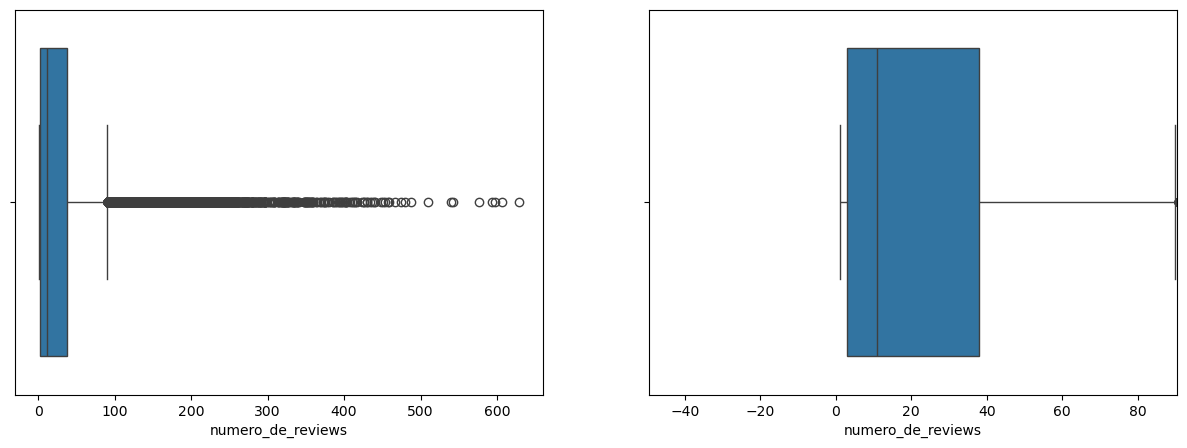

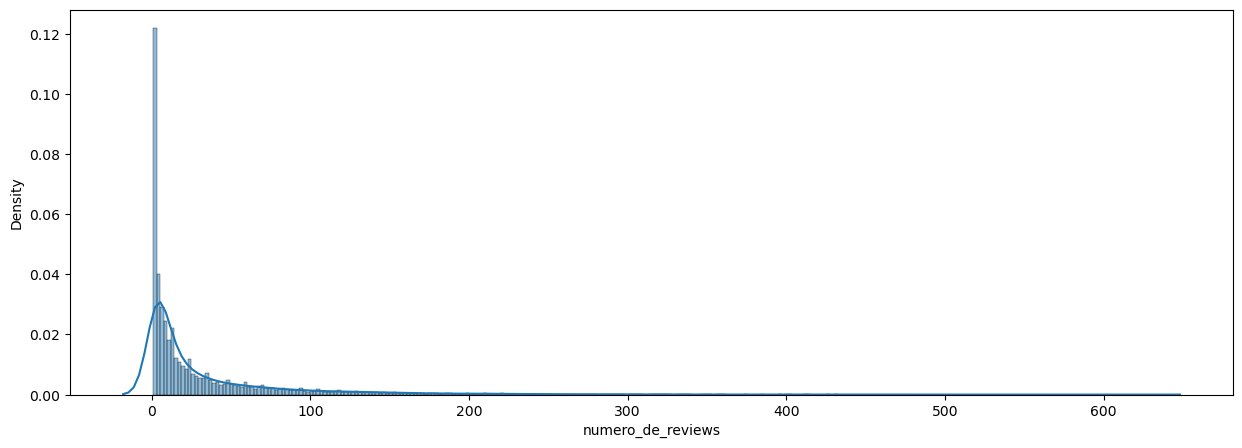

In [25]:
diagrama_caixa(df['numero_de_reviews'])
histograma(df['numero_de_reviews'])

In [26]:
li, ls = limites(df['numero_de_reviews'])
print(f'LS: {ls}, LI: {li}')

LS: 90.5, LI: -49.5


In [27]:
df, linhas_removidas = excluir_outliers(df, 'numero_de_reviews')
print('{} linhas removidas'.format(linhas_removidas))

3307 linhas removidas


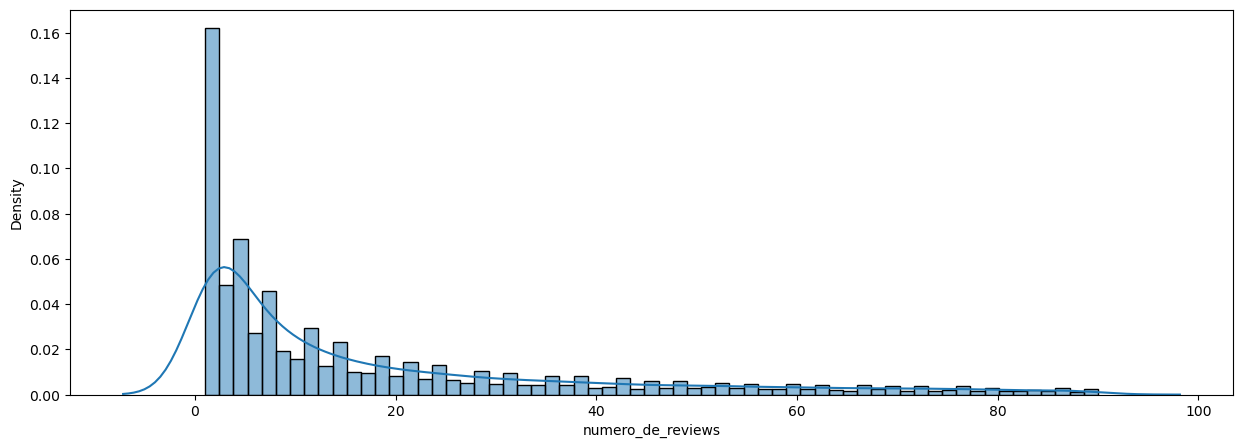

In [28]:
# Verificando o histograma para a coluna após a remoção dos outliers
histograma(df['numero_de_reviews'])

#### 3.5. calculado_host_listings_count

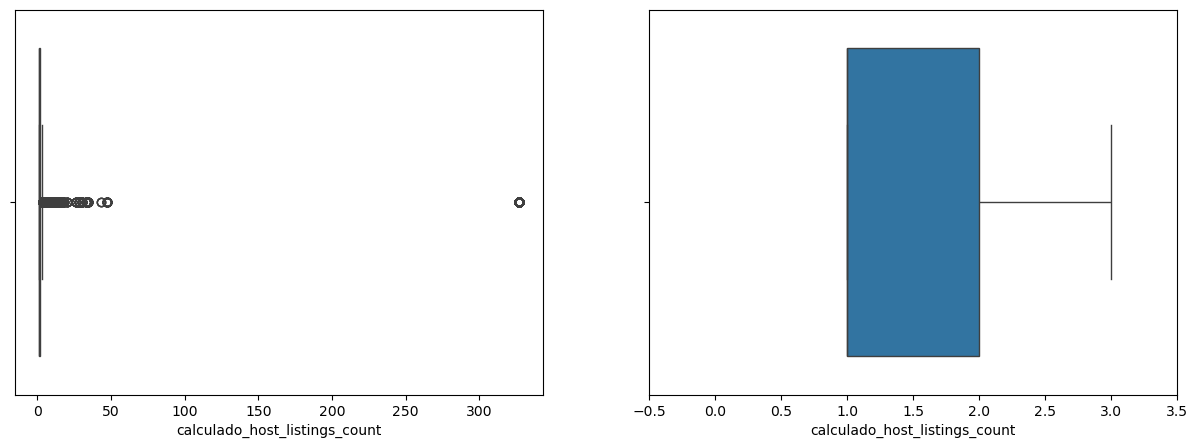

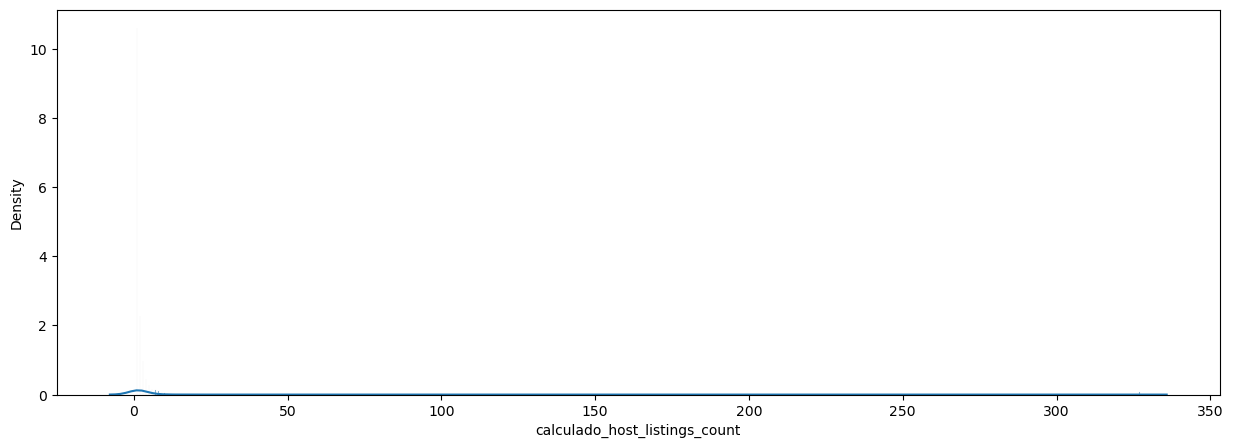

In [29]:
diagrama_caixa(df['calculado_host_listings_count'])
histograma(df['calculado_host_listings_count'])

In [30]:
li, ls = limites(df['calculado_host_listings_count'])
print(f'LS: {ls}, LI: {li}')

LS: 3.5, LI: -0.5


#### 3.6. reviews_por_mes

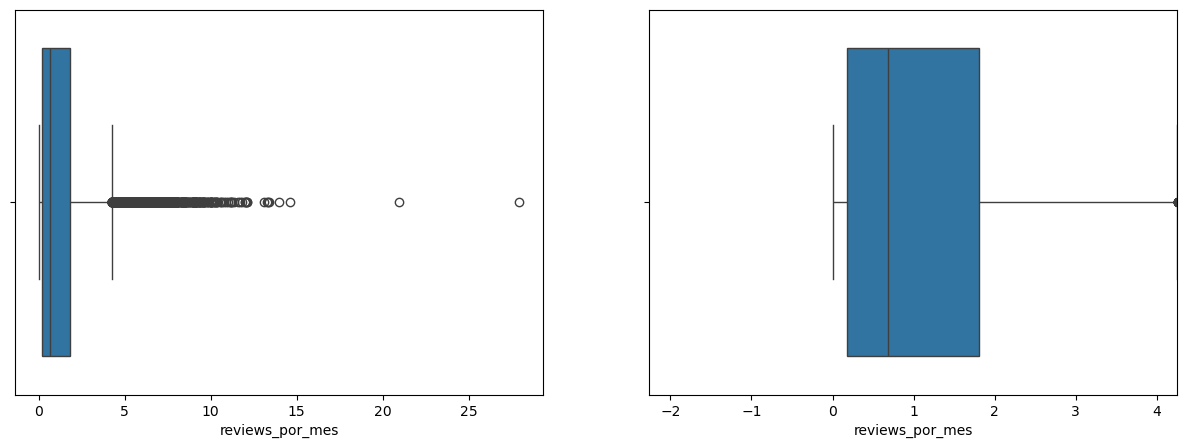

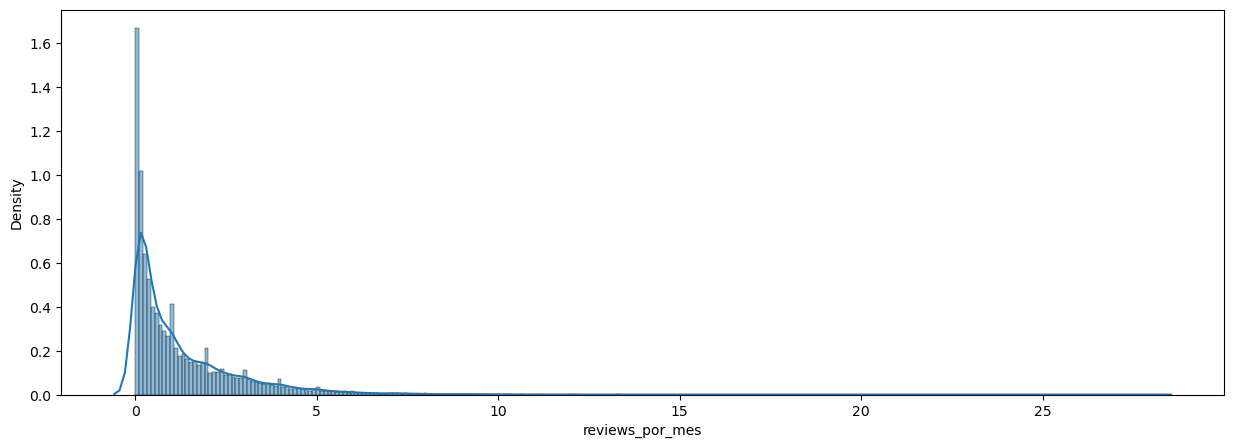

In [31]:
diagrama_caixa(df['reviews_por_mes'])
histograma(df['reviews_por_mes'])

In [32]:
li, ls = limites(df['reviews_por_mes'])
print(f'LS: {ls}, LI: {li}')

LS: 4.255000000000001, LI: -2.265


#### 3.7. disponibilidade_365

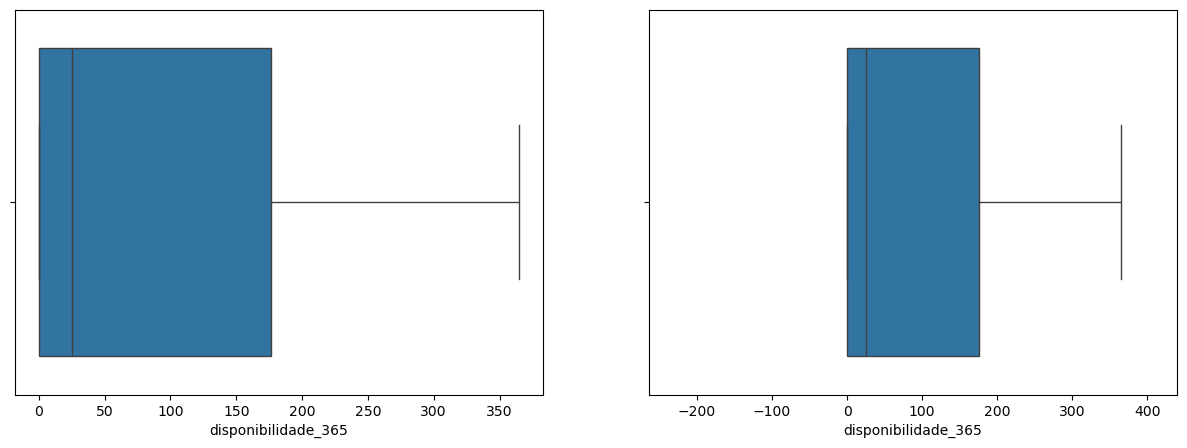

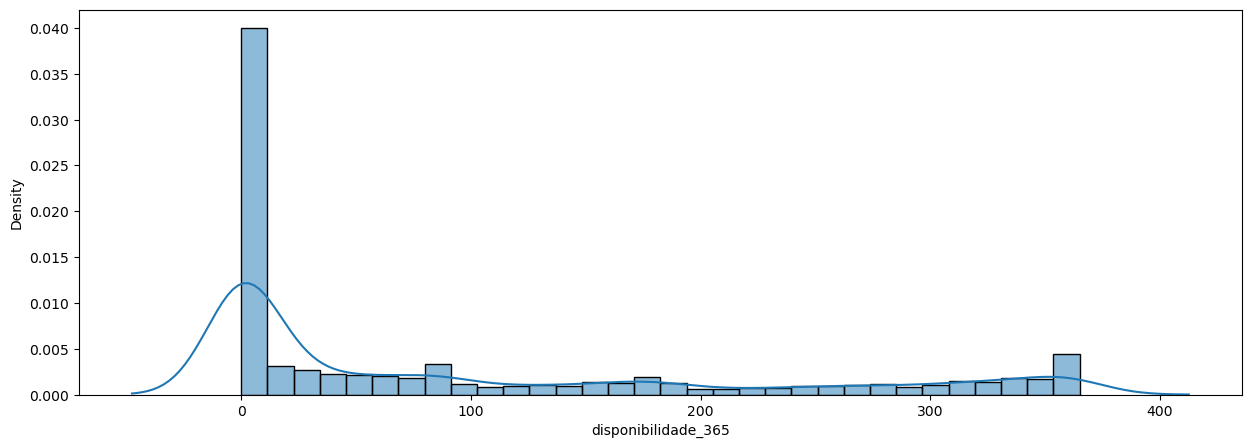

In [33]:
diagrama_caixa(df['disponibilidade_365'])
histograma(df['disponibilidade_365'])

In [34]:
li, ls = limites(df['disponibilidade_365'])
print(f'LS: {ls}, LI: {li}')

LS: 440.0, LI: -264.0


#### 3.8. Verificando relação entre colunas

In [35]:
# Exibindo as estatísticas para a coluna 'room_type' com relação ao preço
df.groupby('room_type')['price'].describe()

count        mean        std   min    25%    50%    75%  \
room_type                                                                    
Entire home/apt  14073.0  160.290414  61.325386  10.0  113.0  150.0  200.0   
Private room     14386.0   78.489573  39.065026  10.0   51.0   70.0   94.0   
Shared room        699.0   57.866953  36.392768  10.0   34.0   49.0   75.0   

                   max  
room_type               
Entire home/apt  321.0  
Private room     320.0  
Shared room      320.0

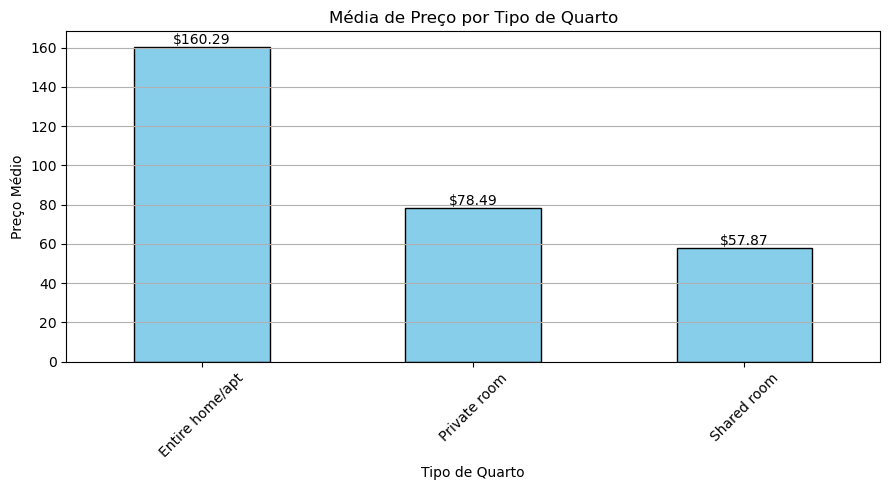

In [36]:
# Plotar o gráfico de colunas
plt.figure(figsize=(9, 5))
df.groupby('room_type')['price'].mean().plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Média de Preço por Tipo de Quarto')
plt.xlabel('Tipo de Quarto')
plt.ylabel('Preço Médio')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adicionar valores nas colunas
for index, value in enumerate(df.groupby('room_type')['price'].mean()):
    plt.text(index, value, f'${value:.2f}', ha='center', va='bottom')

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [37]:
# Exibindo as estatísticas para a coluna 'bairro_group' com relação ao preço
df.groupby('bairro_group')['price'].describe()

count        mean        std   min   25%    50%    75%    max
bairro_group                                                                  
Bronx            739.0   76.174560  46.133958  20.0  45.0   65.0   95.0  309.0
Brooklyn       12784.0  106.016740  60.174176  10.0  60.0   90.0  140.0  320.0
Manhattan      11663.0  142.111378  67.822884  10.0  89.0  130.0  190.0  321.0
Queens          3709.0   89.853060  53.264987  10.0  51.0   75.0  110.0  320.0
Staten Island    263.0   87.627376  56.680283  13.0  50.0   75.0  105.0  300.0

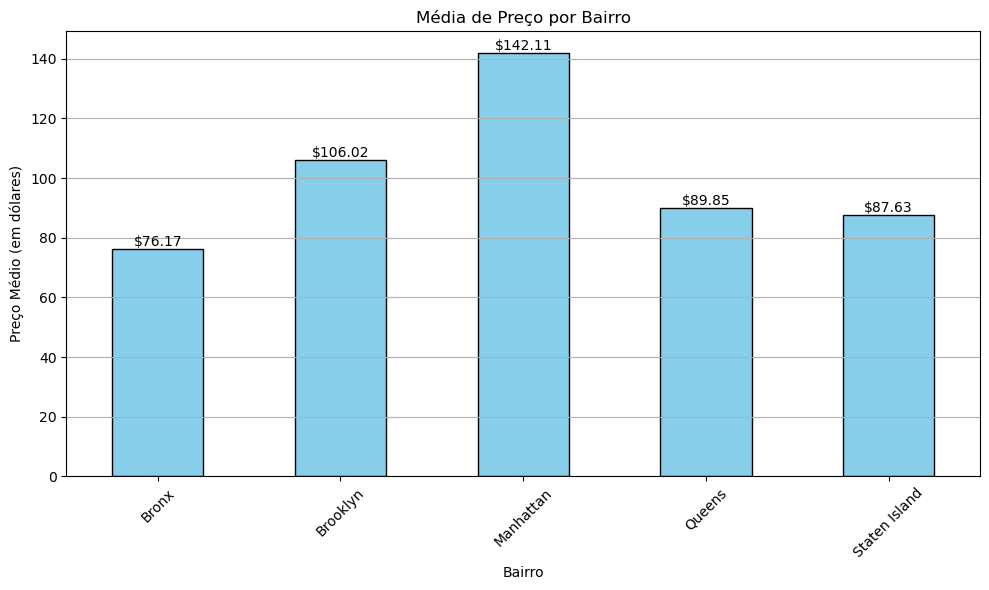

In [38]:
# Plotar o gráfico de colunas
plt.figure(figsize=(10, 6))
df.groupby('bairro_group')['price'].mean().plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Média de Preço por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Preço Médio (em dólares)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adicionar valores nas colunas
for index, value in enumerate(df.groupby('bairro_group')['price'].mean()):
    plt.text(index, value, f'${value:.2f}', ha='center', va='bottom')

# Exibir o gráfico
plt.tight_layout()

In [39]:
# Exibindo as estatísticas para a coluna 'bairro_group' com relação a disponibilidade
df.groupby('bairro_group')['disponibilidade_365'].describe()

count        mean         std  min   25%    50%    75%    max
bairro_group                                                                  
Bronx            739.0  163.305819  136.337582  0.0  34.5  141.0  313.0  365.0
Brooklyn       12784.0   90.453223  121.228887  0.0   0.0   18.0  163.0  365.0
Manhattan      11663.0   81.000171  116.484387  0.0   0.0    8.0  141.0  365.0
Queens          3709.0  143.102993  133.867634  0.0   5.0   96.0  283.0  365.0
Staten Island    263.0  200.973384  128.015964  0.0  82.0  216.0  325.5  365.0

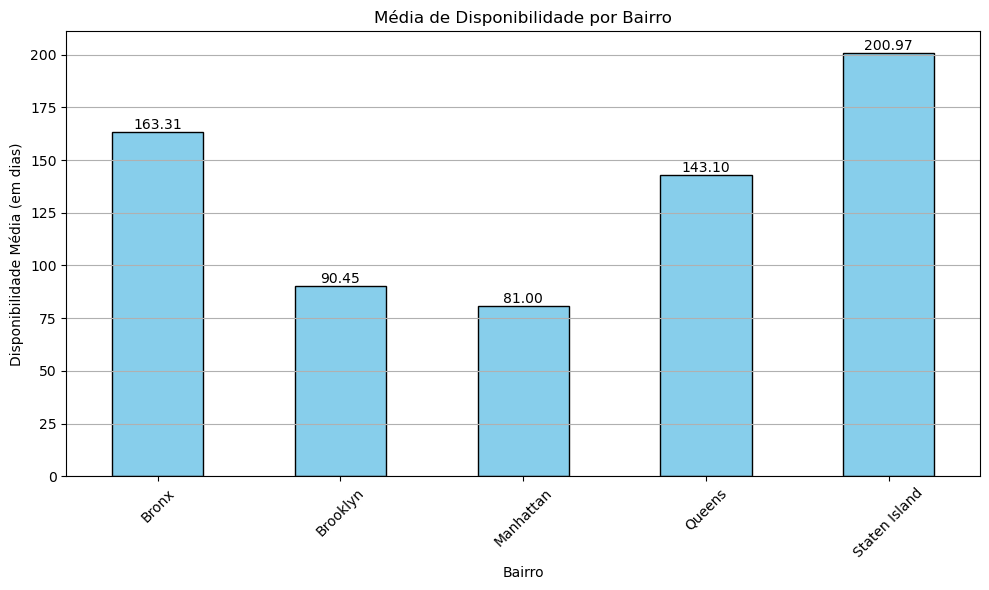

In [40]:
# Plotar o gráfico de colunas
plt.figure(figsize=(10, 6))
df.groupby('bairro_group')['disponibilidade_365'].mean().plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Média de Disponibilidade por Bairro')
plt.xlabel('Bairro')
plt.ylabel('Disponibilidade Média (em dias)')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adicionar valores nas colunas
for index, value in enumerate(df.groupby('bairro_group')['disponibilidade_365'].mean()):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

# Exibir o gráfico
plt.tight_layout()

**Analisando a disponibilidade por bairro, observa-se que o bairro Manhattan tem em média a menor disponibilidade. Considerando que o preço médio cobrado em Manhattan é o maior com bastante folga, e tendo em vista que essa região possui a maior procura, é bastante razoável sugerir que um possível investidor considere essa região como sendo a mais rentável, sendo portanto, a região mais indicada para compra.**

Matriz de Correlação:



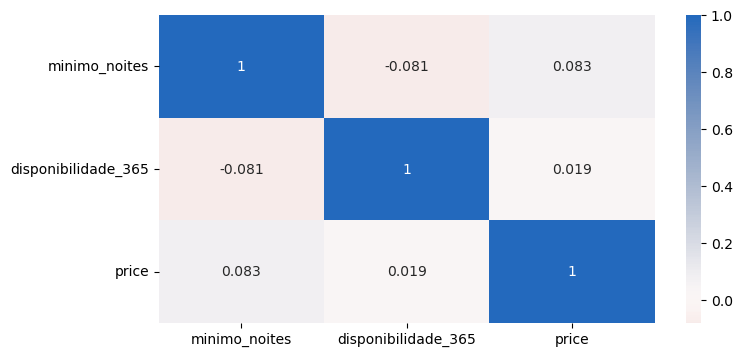

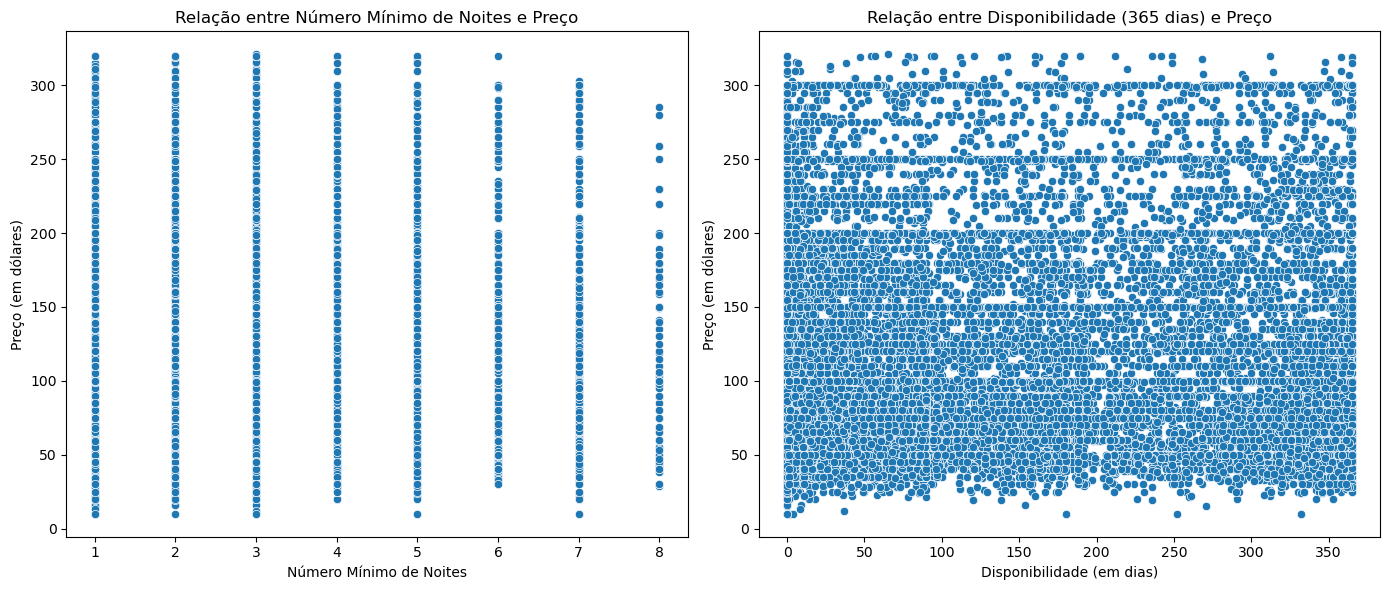

In [41]:
print("Matriz de Correlação:\n")
plt.figure(figsize=(8,4))
sns.heatmap(df[['minimo_noites', 'disponibilidade_365', 'price']].corr(), annot=True, cmap='vlag_r', center=0)

# Gráficos de Dispersão
plt.figure(figsize=(14, 6))

# Gráfico de Dispersão de minimo_noites vs price 
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['minimo_noites'], y=df['price'])
plt.title('Relação entre Número Mínimo de Noites e Preço')
plt.xlabel('Número Mínimo de Noites')
plt.ylabel('Preço (em dólares)')

# Gráfico de Dispersão de disponibilidade_365 vs price
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['disponibilidade_365'], y=df['price'])
plt.title('Relação entre Disponibilidade (365 dias) e Preço')
plt.xlabel('Disponibilidade (em dias)')
plt.ylabel('Preço (em dólares)')

plt.tight_layout()
plt.show()


- **A partir do gráfico de dispersão acima, percebe-se que não não há interferência clara no preço por parte do número mínimo de noites.**
- **Com relação à disponibilidade e o preço, percebe-se os que pontos estão espalhados de forma bastante aleatória no gráfico não demostrando um padrão evidente. Há uma alta densidade de imóveis em toda a faixa de disponibilidade, o que sugere que o preço da diária não varia sistematicamente com o número de dias disponíveis.**
- **A matriz de confusão corrobora o que foi concluído a partir dos gráficos de dispersão, indicando uma baixa correlação entre as variáveis analisadas e o preço.**
- **Os valores discrepantes foram excluídos da análise e indicam propriedades de alto valor ou anúncios especiais. É importante levar isso em conta ao interpretar as tendências gerais.**

In [42]:
# Exibindo os nomes, bairros e preços das 50 propriedades de mais alto valor
df[['nome','bairro_group', 'price']].sort_values('price', ascending=False).head(50)

nome bairro_group  price
46643             Charming 3BR Apt in Downtown Manhattan    Manhattan    321
27561  Super Cute Family Friendly Cozy Loft Suite For...    Manhattan    320
36691         Warm and Cozy two bedroom in prime Chelsea    Manhattan    320
5203                  Hey Beautiful Brooklyn Brownstone!     Brooklyn    320
46890            ★★★Chic place in center of Manhattan★★★    Manhattan    320
23578             Spacious 5th Ave - Semi Pvt Bed & Bath    Manhattan    320
42920      Looks Like A Calvin Klein Ad!  Manhattan Loft    Manhattan    320
45882            Cozy 2Bed in the Heart of East Village!    Manhattan    320
14022                       Chic and Cozy Chinatown Loft    Manhattan    320
47101             Best Value ❤ Memorable Vacation in NYC    Manhattan    320
28697     East Williamsburg’s Spacious Sun-drenched Apt.     Brooklyn    320
17898    1 Room in 2 Bed Apt in the heart of Nolita/Soho    Manhattan    320
24801              Coolest Apartment at Great Location!!    Manhattan    320
45416                                          M's Place       Queens    320
7181                     Large Penthouse in Williamsburg     Brooklyn    320
8391     3 Bedroom Apt in Williamsburg w Private Rooftop     Brooklyn    320
44918         Bright & Cozy 3BR Apartment in Wall Street    Manhattan    320
44764            Beautiful three bedroom on Wall Street!    Manhattan    320
35649                 Oasis in the heart of Williamsburg     Brooklyn    320
47183     Fantastic 2BRM - 2 Minute Walk to Times Square    Manhattan    320
46383  Amazing 2 bedrooms in the heart of the Upper East    Manhattan    320
46318                     Modern Oversized 3bedroom Home    Manhattan    319
42562       Zen Sanctuary! Stunning View, Prime Location     Brooklyn    319
23821                             West Village Apartment    Manhattan    319
46242                         Beautiful 3bd Village Home    Manhattan    319
10117  West 57th Hilton Breakfast/Wine 30 sec from Pa...    Manhattan    319
13812        Beautiful 2 bed Artists Loft - Williamsburg     Brooklyn    319
26588                The Notorious B.N.B. { The Shasha }     Brooklyn    319
16444   2BR heart of Williamsburg, luxury hipster heaven     Brooklyn    319
4886      Huge Artist Loft with BBQ deck -  WILLIAMSBURG     Brooklyn    318
18212     Amazing Location 2 BR 2 Full Bath East Village    Manhattan    316
4757                  Modern rowhouse in prime Ft Greene     Brooklyn    316
41933         Sonder | The Nash | Original 1BR + Rooftop    Manhattan    316
47773   Gorgeous 2BR / 2BA & Patio in Prime East Village    Manhattan    315
47377     Prime East Village *Sunny & Spacious* 2BR Flat    Manhattan    315
23751                         A real New York experience    Manhattan    315
6640                      Designer 1BD w/ backyard space    Manhattan    315
27283  UWS Jewel, oval living room in a charming home...    Manhattan    315
13449            Spacious 1 bedroom in the heart of Soho    Manhattan    315
34189    NYC Spacious 3 BR / Private Entrance + Backyard     Brooklyn    315
16088     Mid Century Modern Greenwich Village 1 Bedroom    Manhattan    315
38450            A slice of luxury In Cozy Chelsea loft!    Manhattan    315
1086                              West Village Gem - 2BR    Manhattan    315
38829           East Village Gem for 7, 1 block to train    Manhattan    313
44346      3 Bedroom Apartment in Midtown - Amazing Deal    Manhattan    311
1101       Curated 1BR on the prettiest block of the LES    Manhattan    311
5862                 5Bedroom Manhattan townhome triplex    Manhattan    310
45137   Cozy Home in Safe Neighborhood Near Times Square    Manhattan    310
31312    Cozy & quiet 2 bedroom apt in a great location!    Manhattan    310
726                  Bright unique designer loft in Soho    Manhattan    310

**Ao analisar os nomes nos anúncios percebe-se algumas curiosidades:**

- **Alguns locais de maior prestígio ou mais conhecidos aparecem no título, como por exemplo "Central Park".**
- **Títulos que destacam luxo, modernidade e vistas.**
- **Foco em descrever brevemente as características do imóvel como quantidade de quartos, banheiros e tipo de cama**

#### 3.9. Visualização de Mapa das Propriedades

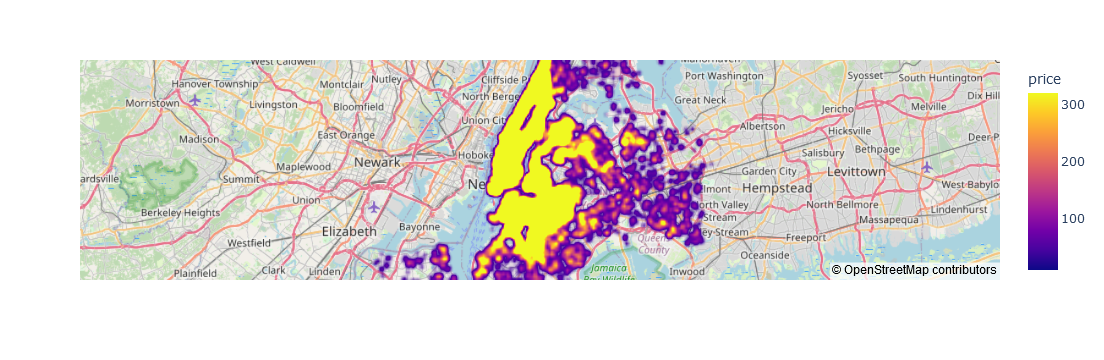

In [43]:
centro_mapa = {'lat':df.latitude.mean(), 'lon':df.longitude.mean()}

mapa = px.density_mapbox(df, lat='latitude', lon='longitude', z='price', radius=5,
                        center=centro_mapa, zoom=9, mapbox_style='open-street-map')
mapa.show()

É possivel observar que há uma maior quantidade de propriedades na região de Manhattan próximo ao Central Park e Brooklyn. Essas são também as propriedades com maior preço.

### 4. Realizando ajustes nos dados para alimentar o modelo

Com base nos dados disponibilizados e no tipo de problema proposto, é evidente que se trata de um problema de **regressão**, onde a variável alvo é o preço e as variáveis independentes são as outras colunas que explicam aquele preço. Sendo assim, vamos realizar as transformações relevantes para este caso e criar um modelo para realizar a previsão a partir de algoritmos de regressão.

- Vamos basicamente olhar feature por feature para:
  
  1. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir.
  2. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
  3. Realizar encoding para as features não numéricas
  5. Normalizar os valores 

Uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir algumas colunas da nossa base
Colunas que vamos excluir:
- IDs
- Nomes de hosts
- Nomes de anúncios

In [44]:
# Criando cópia do df
df_limpo = df.copy()

In [45]:
# Removendo as colunas de IDs, Nomes e 'ultima_review'
df = df.drop(['id','nome','host_name','host_id','ultima_review'], axis=1)

<Axes: >

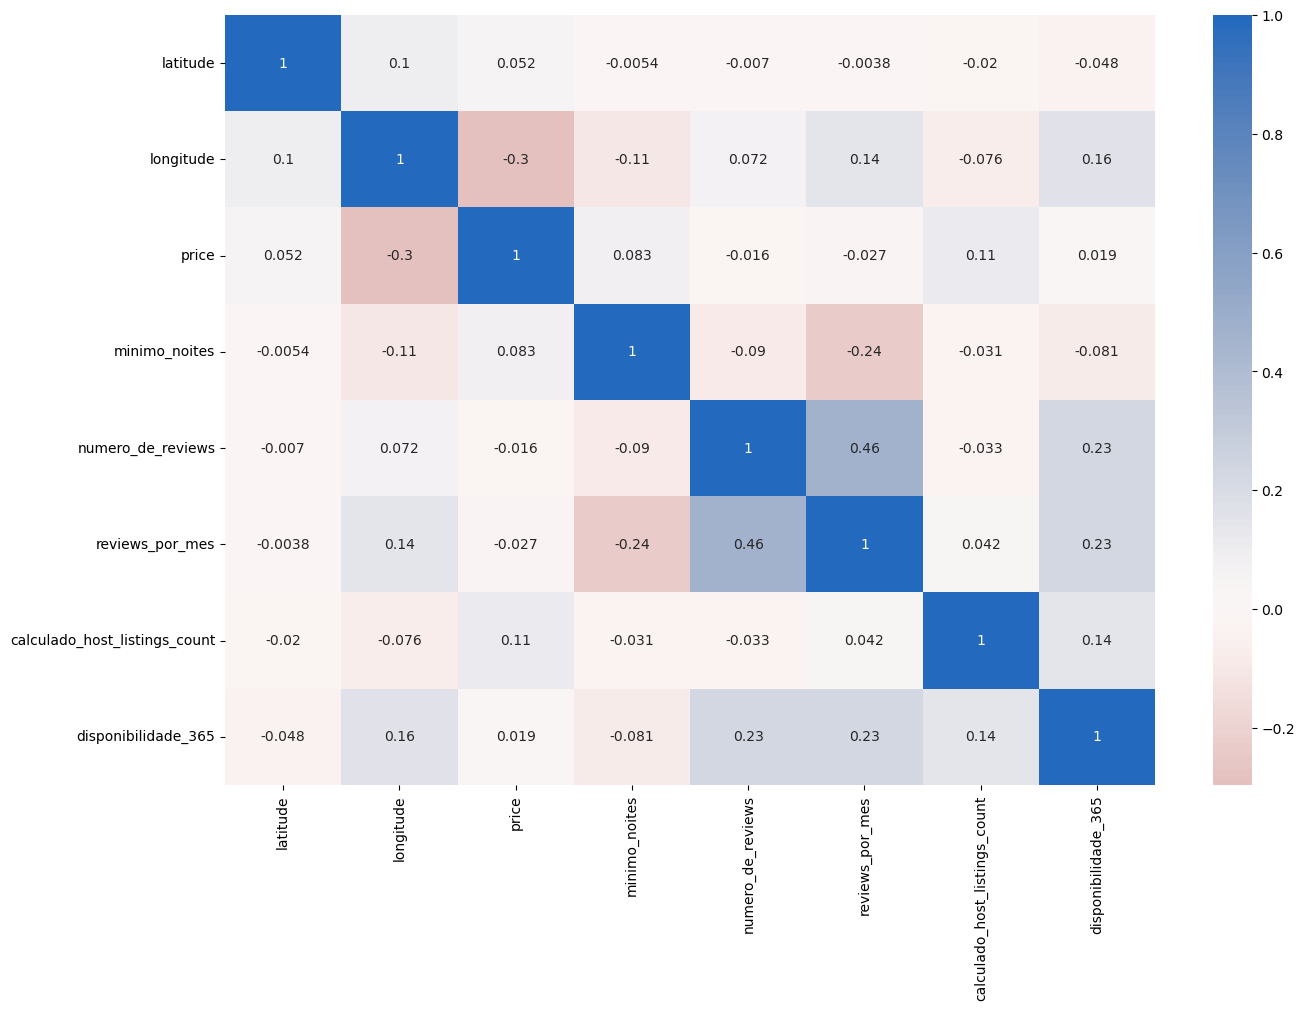

In [46]:
# Correlação entre as colunas 
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='vlag_r', center=0)

- **Não há colunas com forte correlação entre si, sendo assim, manteremos todas as colunas restantes.**

#### 4.1. Tratando colunas do tipo texto

In [47]:
# Verificando a quantide de valores únicas para a coluna 'bairro'
df['bairro'].nunique()

218

Temos muitos valores distintos nessa coluna, e como já temos uma outra coluna que 'agrupa' os imóveis em uma quantidade de valores menor, iremos excluir essa coluna 'bairro' e trabalhar apenas com a coluna 'bairro_group'

In [48]:
df = df.drop('bairro', axis=1)

#### Encoding

Precisamos Ajustar as features de Categoria (features em que os valores da coluna são textos). Vamos utilizar o método de encoding de variáveis com o OneHotEncoder

In [49]:
print(df.iloc[0])

bairro_group                           Manhattan
latitude                                40.75362
longitude                              -73.98377
room_type                        Entire home/apt
price                                        225
minimo_noites                                  1
numero_de_reviews                             45
reviews_por_mes                             0.38
calculado_host_listings_count                  2
disponibilidade_365                          355
Name: 0, dtype: object


In [50]:
# Realizando encoding para as colunas categórias
colunas_categorias = ['bairro_group', 'room_type']

# Criando o OneHotEncoder
oh_encoder = OneHotEncoder(sparse_output=False)

# Ajustando e transformando os dados
encoded = oh_encoder.fit_transform(df[colunas_categorias])
encoded_df = pd.DataFrame(encoded, columns=oh_encoder.get_feature_names_out(colunas_categorias))

# Anexando ao DataFrame original
encoded_df.index = df.index
df_cod = df.join(encoded_df)

# Excluindo as colunas originais
df_cod = df_cod.drop(colunas_categorias, axis=1)

display(df_cod.head(10))

latitude  longitude  price  minimo_noites  numero_de_reviews  \
0   40.75362  -73.98377    225              1                 45   
4   40.74767  -73.97500    200              3                 74   
9   40.80316  -73.96545    135              5                 53   
17  40.67592  -73.94694     99              3                 53   
19  40.71842  -73.95718    299              3                  9   
21  40.67989  -73.97798     80              1                 39   
22  40.68001  -73.97865    110              2                 71   
23  40.68371  -73.94028    120              2                 88   
24  40.65599  -73.97519     60              1                 19   
30  40.81305  -73.95466     52              2                 88   

    reviews_por_mes  calculado_host_listings_count  disponibilidade_365  \
0              0.38                              2                  355   
4              0.59                              1                  129   
9              0.43                              1                    6   
17             4.44                              1                   21   
19             0.07                              1                    0   
21             0.37                              6                  364   
22             0.61                              6                  304   
23             0.73                              2                  233   
24             1.37                              2                   85   
30             1.42                              1                  255   

    bairro_group_Bronx  bairro_group_Brooklyn  bairro_group_Manhattan  \
0                  0.0                    0.0                     1.0   
4                  0.0                    0.0                     1.0   
9                  0.0                    0.0                     1.0   
17                 0.0                    1.0                     0.0   
19                 0.0                    1.0                     0.0   
21                 0.0                    1.0                     0.0   
22                 0.0                    1.0                     0.0   
23                 0.0                    1.0                     0.0   
24                 0.0                    1.0                     0.0   
30                 0.0                    0.0                     1.0   

    bairro_group_Queens  bairro_group_Staten Island  \
0                   0.0                         0.0   
4                   0.0                         0.0   
9                   0.0                         0.0   
17                  0.0                         0.0   
19                  0.0                         0.0   
21                  0.0                         0.0   
22                  0.0                         0.0   
23                  0.0                         0.0   
24                  0.0                         0.0   
30                  0.0                         0.0   

    room_type_Entire home/apt  room_type_Private room  room_type_Shared room  
0                         1.0                     0.0                    0.0  
4                         1.0                     0.0                    0.0  
9                         1.0                     0.0                    0.0  
17                        1.0                     0.0                    0.0  
19                        1.0                     0.0                    0.0  
21                        0.0                     1.0                    0.0  
22                        0.0                     1.0                    0.0  
23                        1.0                     0.0                    0.0  
24                        0.0                     1.0                    0.0  
30                        0.0                     1.0                    0.0

#### 4.2. Padronizando os valores
**A padronização dos dados é crucial em muitos modelos de Machine Learning. Isso é feito para garantir que todas as variáveis estejam na mesma escala, o que ajuda a:**
- **Facilita a convergência mais rápida dos modelos durante o treinamento.**
- **Melhora a precisão das previsões dos modelos.**
- **Permite que os modelos aprendam pesos mais apropriados para cada característica (ou feature).**

In [51]:
# Definindo random_state para permitir replicabilidade do modelo
random_state = 2025

In [52]:
# Separando a base em x e y
y = df_cod['price']
x = df_cod.drop('price', axis=1)

# criando x, y de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = random_state)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((23326, 15), (5832, 15), (23326,), (5832,))

In [53]:
# Padronizar os dados
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### 5. Métricas de avaliação

Por se tratar de um problema de regressão, foram escolhidas duas métricas de desempenho: R² (coeficiente de determinação) e MAE (Mean Absolute Error, ou Erro Médio Absoluto). Essas métricas complementam-se e oferecem uma visão mais abrangente sobre a performance do modelo:

- MAE fornece uma medida do erro médio absoluto, ajudando a identificar o quão próximas as previsões estão dos valores reais em média.

- R² indica o quão bem o modelo consegue explicar a variabilidade dos dados.

Utilizar ambas as métricas permite uma análise mais completa e precisa da performance do modelo de regressão.

In [54]:
# Função para exibir métricas de validação cruzada
def avaliar_modelo(nome_modelo, modelo, X, y):
    print(f"\nModelo: {nome_modelo}")

    # Validação cruzada para R²
    r2_scores = cross_val_score(modelo, X, y, cv=5, scoring='r2', n_jobs=-1)
    mean_r2 = np.mean(r2_scores)
    print(f"R² (Validação cruzada): {mean_r2:.4f}")

    # Validação cruzada para MAE
    mae_scores = cross_val_score(modelo, X, y, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    mean_mae = -np.mean(mae_scores)  # Reverter sinal, pois o sklearn retorna o negativo de MAE
    print(f"MAE (Validação cruzada): {mean_mae:.4f}")

    return mean_r2, mean_mae

### 6. Escolha dos modelos a serem utilizados
  1. Ridge Regression
  2. Linear Regression
  3. Extra Trees Regressor
  4. RandomForest Regressor
  5. Neural Networks (MLP Regressor)

### 7. Criando os modelos, realizando treinamento, teste e avaliação

In [55]:
modelos = {
    'Ridge': Ridge(),
    # 'LinearRegression': LinearRegression(),
    # 'ExtraTreesRegressor': ExtraTreesRegressor(),
    # 'RandomForestRegressor': RandomForestRegressor(),
    # 'MLPRegressor': MLPRegressor()
}


# Criando dicionário com os modelos e hiperparâmetros a serem otimizados
hiperparametros = {
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0, 100.0],  # Regularização L2
        'fit_intercept': [True, False],    # Ajustar intercepto ou não
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Algoritmo de otimização
    },
    

    # 'LinearRegression': {
    #     'n_jobs': [-1]                    # Paralelismo para grandes conjuntos de dados
    # },
    

    # 'ExtraTreesRegressor': {
    #     'n_estimators': [100, 200, 500],              # Número de árvores
    #     'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],  # Critério de divisão
    #     'max_depth': [None, 5, 10, 20],              # Profundidade máxima das árvores
    #     'min_samples_split': [2, 5, 10],             # Mínimo de amostras para split
    #     'min_samples_leaf': [1, 2, 5],               # Mínimo de amostras por folha
    #     'max_features': ['sqrt', 'log2', None],      # Número máximo de features por split
    #     'bootstrap': [True, False],                  # Amostragem com substituição
    #     'random_state': [11]                         # Semente para reprodutibilidade
    # },
    

    # 'RandomForestRegressor': {
    #     'n_estimators': [100, 200, 500],             # Número de árvores
    #     'criterion': ['squared_error', 'absolute_error'],  # Critério de divisão
    #     'max_depth': [None, 5, 10, 20],             # Profundidade máxima das árvores
    #     'min_samples_split': [2, 5, 10],            # Mínimo de amostras para split
    #     'min_samples_leaf': [1, 2, 5],              # Mínimo de amostras por folha
    #     'random_state': [11]                       # Semente para reprodutibilidade
    # },
    
#     'MLPRegressor': {
#        'hidden_layer_sizes': [(50,), (100,)],	              # Estrutura das camadas ocultas
#        'activation': ['relu', 'tanh'],	                      # Função de ativação
#        'solver': ['adam', 'lbfgs'],                           # Algoritmo de otimização
#        'alpha': [0.0001, 0.001],	                          # Regularização L2
#        'learning_rate': ['constant', 'adaptive'],             # Estratégia de taxa de aprendizado
#        'learning_rate_init': [0.0001, 0.001],                 # Taxa inicial de aprendizado
#        'max_iter': [500, 1000],                               # Iterações máximas
#        'random_state': [11],                                  # Semente para reprodutibilidade
#        'batch_size': [32, 64]                                 # Tamanho do batch para treinamento
#     }
}


# Função para encontrar os melhores parâmetros
def encontrar_melhores_hiperparametros(modelos, hiperparametros):
    melhores_hiperparametros = {}
    
    for nome_modelo, modelo in modelos.items():
        print(f'Ajustando parâmetros para {nome_modelo}...')
        
        grid_search = GridSearchCV(estimator=modelo, param_grid=hiperparametros[nome_modelo], error_score='raise', cv=5, n_jobs=-1)
        grid_search.fit(x_train_scaled, y_train)

        # Armazenar os melhores parâmetros e as métricas
        melhores_hiperparametros[nome_modelo] = grid_search.best_params_
    
    return melhores_hiperparametros


# Encontrar os melhores parâmetros
melhores_hiperparametros = encontrar_melhores_hiperparametros(modelos, hiperparametros)

# Imprimindo os melhores parâmetros
for modelo, parametros in melhores_hiperparametros.items():
    print(modelo, ':', parametros)

Ajustando parâmetros para Ridge...
Ridge : {'alpha': 10.0, 'fit_intercept': True, 'solver': 'sag'}


In [56]:
# Instanciando os modelos com os hiperparâmetros
ridge = Ridge(**melhores_hiperparametros['Ridge'])
linear_regression = LinearRegression(n_jobs=-1)
extra_trees = ExtraTreesRegressor(n_jobs=-1, random_state=random_state)
random_forest = RandomForestRegressor(n_jobs=-1, random_state=random_state)
mlp = MLPRegressor(max_iter=1000, random_state=random_state)

modelos = {
    'Ridge': ridge,
    'LinearRegression': linear_regression,
    'ExtraTreesRegressor': extra_trees,
    'RandomForestRegressor': random_forest,
    'MLPRegressor': mlp
}

In [57]:
# Treinamento, teste e avaliação
for nome_modelo, modelo in modelos.items():
    # Medir o tempo de treinamento
    inicio = time.time()
    modelo.fit(x_train_scaled, y_train)
    fim = time.time()
    tempo_execucao = fim - inicio

    # Testar no conjunto de teste
    previsao = modelo.predict(x_test_scaled)

    # Validação cruzada
    mean_r2, mean_mae = avaliar_modelo(nome_modelo, modelo, x_train_scaled, y_train)

    # Mostrar o tempo de execução
    print(f"Tempo de Treinamento: {time.strftime('%H:%M:%S', time.gmtime(tempo_execucao))}")
    print('-'*100)


Modelo: Ridge
R² (Validação cruzada): 0.4940
MAE (Validação cruzada): 34.5009
Tempo de Treinamento: 00:00:00
----------------------------------------------------------------------------------------------------

Modelo: LinearRegression
R² (Validação cruzada): 0.4940
MAE (Validação cruzada): 34.4846
Tempo de Treinamento: 00:00:00
----------------------------------------------------------------------------------------------------

Modelo: ExtraTreesRegressor
R² (Validação cruzada): 0.5426
MAE (Validação cruzada): 31.6816
Tempo de Treinamento: 00:00:00
----------------------------------------------------------------------------------------------------

Modelo: RandomForestRegressor
R² (Validação cruzada): 0.5557
MAE (Validação cruzada): 31.4379
Tempo de Treinamento: 00:00:01
----------------------------------------------------------------------------------------------------

Modelo: MLPRegressor
R² (Validação cruzada): 0.5616
MAE (Validação cruzada): 31.3496
Tempo de Treinamento: 00:00:1

### Análise do melhor modelo

- **Modelo escolhido: ExtraTreesRegressor**

**O modelo MLPRegressor que utiliza redes neurais obteve os melhores resultados de R² e MAE. Contudo, a diferença nas métricas foi muito pequena entre ExtraTrees, RandomForest e MLP, a não ser pelo tempo de treinamento que foi consideravelmente maior no modelo MLP. Enquanto o RandomForest e o ExtraTrees levaram apenas 1 segundo ou menos para treinar e testar, o modelo MLP levou 19 segundos para realizar essa mesma tarefa.**
  
**Os modelos LinearRegression e Ridge obteviveram os piores resultados, com valores de R² e MAE pouco piores do que os outros modelos.**

#### Analisando as importâncias das features

In [58]:
# Exibindo as importâncias do modelo ExtraTrees
importancias_et = pd.DataFrame(data=extra_trees.feature_importances_, # Importâncias
                               columns=['et'],
                               index=x_train.columns # Nomes das features
                              )
importancias_et

et
latitude                       0.122069
longitude                      0.114732
minimo_noites                  0.051415
numero_de_reviews              0.066887
reviews_por_mes                0.070599
calculado_host_listings_count  0.037113
disponibilidade_365            0.077009
bairro_group_Bronx             0.000714
bairro_group_Brooklyn          0.003892
bairro_group_Manhattan         0.059013
bairro_group_Queens            0.001254
bairro_group_Staten Island     0.000429
room_type_Entire home/apt      0.390791
room_type_Private room         0.002094
room_type_Shared room          0.001989

ExtraTrees       MLP  RandomForest
room_type_Entire home/apt        0.390791  0.163044      0.390901
latitude                         0.122069  0.121503      0.157680
longitude                        0.114732  0.200378      0.166680
disponibilidade_365              0.077009  0.089458      0.077596
reviews_por_mes                  0.070599  0.011056      0.076763
numero_de_reviews                0.066887  0.010037      0.056309
bairro_group_Manhattan           0.059013  0.075946      0.015535
minimo_noites                    0.051415  0.010737      0.030483
calculado_host_listings_count    0.037113  0.051213      0.021409
bairro_group_Brooklyn            0.003892  0.091659      0.000896
room_type_Private room           0.002094  0.185343      0.002103
room_type_Shared room            0.001989  0.048961      0.002205
bairro_group_Queens              0.001254  0.046307      0.000999
bairro_group_Bronx               0.000714  0.051034      0.000346
bairro_group_Staten Island       0.000429  0.012605      0.000096

<Figure size 1200x600 with 0 Axes>

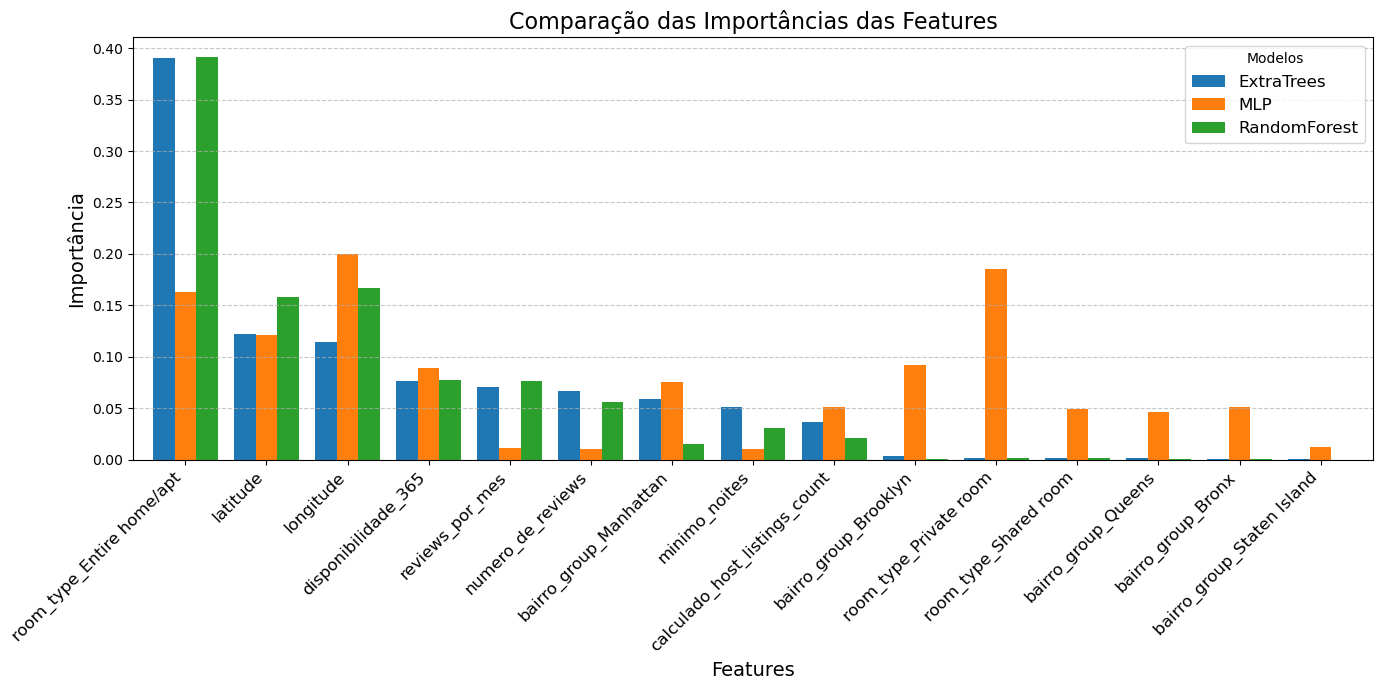

In [59]:
# Exibindo as importâncias dadas para cada variável durante o treinamento do modelo RandomForest
importancias_rf = pd.DataFrame(data=random_forest.feature_importances_, 
                               columns=['RandomForest'],
                              index=x_train.columns 
                             )

# Calculando as importâncias do modelo MLP
result = permutation_importance(mlp, x_train_scaled, y_train, n_repeats=10, random_state=random_state)
importancias_mlp = pd.DataFrame(data= result.importances_mean, # Importância média,
                                columns=['MLP'],
                              index = x_train.columns 
                             )

# Exibindo as importâncias do modelo ExtraTrees
importancias_et = pd.DataFrame(data=extra_trees.feature_importances_, 
                               columns=['ExtraTrees'],
                               index=x_train.columns 
                              )

# Juntando num só df
df_importancias = pd.concat([importancias_et, importancias_mlp, importancias_rf], axis=1)

# Ordenando o DataFrame pelas importâncias do extra_trees
df_importancias = df_importancias.sort_values(by='ExtraTrees', ascending=False)
display(df_importancias)

# Configurar o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Criar o gráfico de barras agrupadas
df_importancias.plot(kind='bar', figsize=(14, 7), width=0.8)

# Adicionar título e rótulos
plt.title('Comparação das Importâncias das Features', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importância', fontsize=14)

# Legendas e ajustes
plt.legend(title='Modelos', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

### 8. Prevendo o preço para um novo apartamento

In [60]:
# Função para adequar os dados:
def adequar_dados(dados):
    # Transformando em DataFrame
    nova_propriedade_df = pd.DataFrame([dados])
    
    # Removendo colunas que não foram usadas 
    nova_propriedade_df = nova_propriedade_df.drop(['id', 'nome', 'host_id', 'host_name', 'bairro', 'ultima_review'], axis=1)
    
    # Aplicando as transformações
    encoded_df = pd.DataFrame(oh_encoder.transform(nova_propriedade_df[colunas_categorias]), columns=oh_encoder.get_feature_names_out(colunas_categorias))
    
    # Anexando ao DataFrame original
    encoded_df.index = nova_propriedade_df.index
    nova_propriedade_df_cod = nova_propriedade_df.join(encoded_df)
    
    # Excluindo as colunas originais
    nova_propriedade_df_cod = nova_propriedade_df_cod.drop(colunas_categorias, axis=1)
    
    # Aplicando a padronização
    nova_propriedade_scaled = scaler.transform(nova_propriedade_df_cod)

    return nova_propriedade_scaled

In [61]:
# Dados do novo imóvel
nova_propriedade = {'id': 2595,
 'nome': 'Skylit Midtown Castle',
 'host_id': 2845,
 'host_name': 'Jennifer',
 'bairro_group': 'Manhattan',
 'bairro': 'Midtown',
 'latitude': 40.75362,
 'longitude': -73.98377,
 'room_type': 'Entire home/apt',
 'minimo_noites': 1,
 'numero_de_reviews': 45,
 'ultima_review': '2019-05-21',
 'reviews_por_mes': 0.38,
 'calculado_host_listings_count': 2,
 'disponibilidade_365': 355}

dados_adequados = adequar_dados(nova_propriedade)
# Agora o novo imóvel está pronto para a previsão

# Realizando a previsão com o modelo treinado
previsao = extra_trees.predict(dados_adequados)

# Exibir o preço previsto
print(f"O preço previsto para o imóvel é: ${previsao[0]:.2f}")

O preço previsto para o imóvel é: $225.00


### 8. Criando Pipeline e salvando o modelo em arquivo .pkl

In [62]:
# Criando dataframes de x e y de treino para treinar o pipeline
y_ = df_limpo['price']
x_ = df_limpo.drop('price', axis=1)
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_, y_, test_size = 0.2, random_state = random_state)

# Definindo as colunas a serem tratadas
colunas_remover = ['id', 'nome', 'host_name', 'host_id', 'ultima_review', 'bairro']
colunas_categorias = ['bairro_group', 'room_type']
colunas_numericas = ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

# Definindo o pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', colunas_remover),  # Remove colunas desnecessárias
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), colunas_categorias),  # Codificação
        ('scaler', StandardScaler(), colunas_numericas)  # Especifica as colunas numéricas para escalonamento
    ]
)

# Criando o pipeline completo com fit e transform
pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('model', extra_trees)    
])

# Ajustando o pipeline corretamente (pré-processador + modelo)
pipeline.fit(x_train_, y_train_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['id', 'nome', 'host_name',
                                                   'host_id', 'ultima_review',
                                                   'bairro']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['bairro_group',
                                                   'room_type']),
                                                 ('scaler', StandardScaler(),
                                                  ['latitude', 'longitude',
                                                   'minimo_noites',
                                                   'numero_de_reviews',
                                                   'reviews_por_mes',
                                                   'calculado_host_listings_count',
                                                   'disponibilidade_365'])])),
                ('model', ExtraTreesRegressor(n_jobs=-1, random_state=2025))])

In [63]:
filename = 'Modelo_Previsao.pkl'

# Salvando o modelo
dump(pipeline, filename)

['Modelo_Previsao.pkl']